# Fraud Dataset Exploration + Model + SHAP

EDA for `Fraud.csv` plus training an XGBoost model (default threshold 0.5), SHAP feature importance, and saving the model bundle to `.pkl`.

In [1]:
# ---- Configuration ----
DATA_PATH = 'Fraud.csv'
PLOT_SAMPLE = 50000    # rows to sample for heavy plots
PAIRPLOT_MAX_COLS = 5  # pairplot column cap
RANDOM_STATE = 42

# Model/SHAP
MODELS_DIR = 'saved_models'
SHAP_BG_MAX = 1000
SHAP_VAL_MAX = 2000


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_context('notebook')
sns.set_style('whitegrid')
pd.set_option('display.max_columns', 100)


In [3]:
# ---- Load data ----
path = Path(DATA_PATH)
assert path.exists(), f'File not found: {path.resolve()}'
df = pd.read_csv(path, low_memory=False)
print('Shape:', df.shape)
print('Columns:', list(df.columns))

# Light dtype optimization
if 'isFraud' in df.columns:
    df['isFraud'] = pd.to_numeric(df['isFraud'], errors='coerce').fillna(0).astype(np.int8)
if 'type' in df.columns and df['type'].dtype == object:
    df['type'] = df['type'].astype('category')
mem_mb = df.memory_usage(deep=True).sum() / (1024**2)
print(f'Memory usage: {mem_mb:.2f} MB')


Shape: (6362620, 10)
Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud']
Memory usage: 1122.34 MB


In [4]:
# ---- Quick peek ----
display(df.head(10))
display(df.tail(5))
display(df.sample(min(5, len(df)), random_state=RANDOM_STATE))


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
3737323,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0
264914,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0
85647,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0
5899326,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0
2544263,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0


In [5]:
# ---- Missing values + stats ----
na_counts = df.isna().sum().sort_values(ascending=False)
na_pct = (df.isna().mean()*100).sort_values(ascending=False)
missing = pd.DataFrame({'missing': na_counts, 'missing_%': na_pct})
display(missing[missing['missing']>0])

num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
display(df[num_cols].describe().T)


,missing,missing_%


,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00


Target counts:
isFraud
0    6354407
1       8213
Name: count, dtype: int64
Target rate: 0.001290820448180152


/var/folders/td/t81p57q93474xft5d0tdyfl00000gn/T/ipykernel_99987/2503267834.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = (df.groupby('type')['isFraud']


,count,frauds,fraud_rate
type,,,
TRANSFER,532909,4097,0.007688
CASH_OUT,2237500,4116,0.001840
CASH_IN,1399284,0,0.000000
DEBIT,41432,0,0.000000
PAYMENT,2151495,0,0.000000


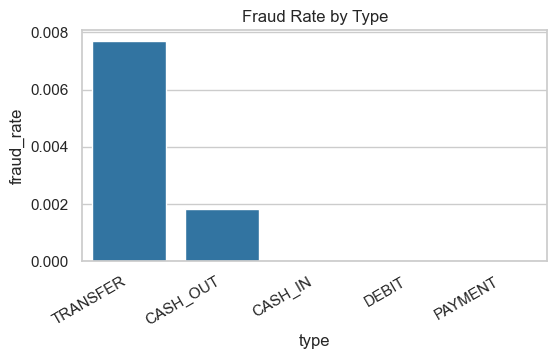

In [6]:
# ---- Target distribution and by type ----
if 'isFraud' in df.columns:
    print('Target counts:')
    print(df['isFraud'].value_counts())
    print('Target rate:', df['isFraud'].mean())
    if 'type' in df.columns:
        tmp = (df.groupby('type')['isFraud']
                 .agg(['count','sum','mean'])
                 .rename(columns={'sum':'frauds','mean':'fraud_rate'})
                 .sort_values('fraud_rate', ascending=False))
        display(tmp)
        plt.figure(figsize=(6,3))
        sns.barplot(x=tmp.index.astype(str), y=tmp['fraud_rate'])
        plt.xticks(rotation=30, ha='right')
        plt.title('Fraud Rate by Type')
        plt.show()


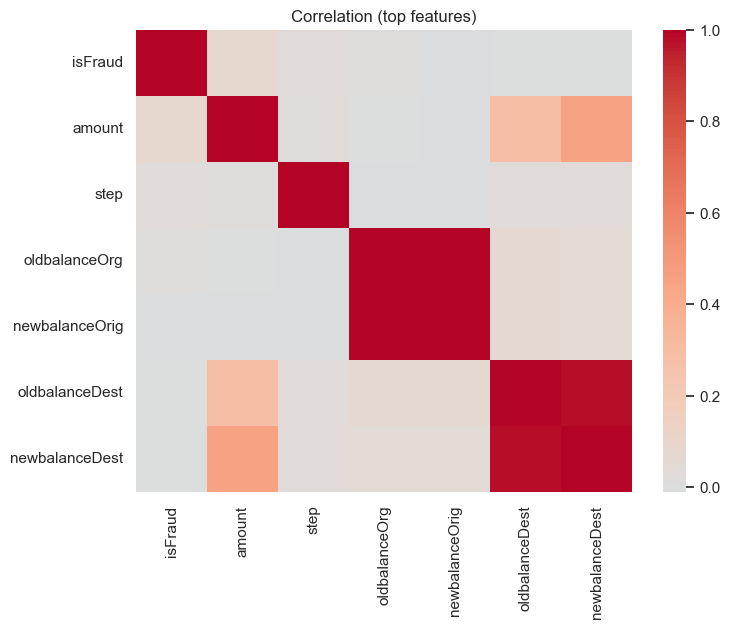

In [7]:
# ---- Correlations (numeric) ----
corr = df[num_cols].corr(numeric_only=True)
if 'isFraud' in corr.columns:
    target_corr = corr['isFraud'].abs().sort_values(ascending=False)
    top_cols = list(target_corr.head(12).index)
else:
    mean_abs = corr.abs().mean().sort_values(ascending=False)
    top_cols = list(mean_abs.head(12).index)
plt.figure(figsize=(8,6))
sns.heatmap(df[top_cols].corr(numeric_only=True), annot=False, cmap='coolwarm', center=0)
plt.title('Correlation (top features)')
plt.show()


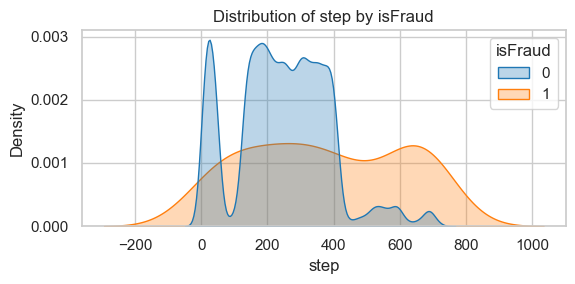

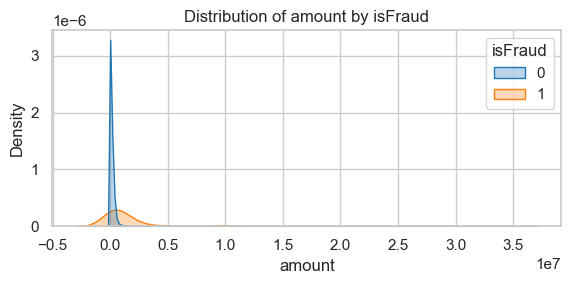

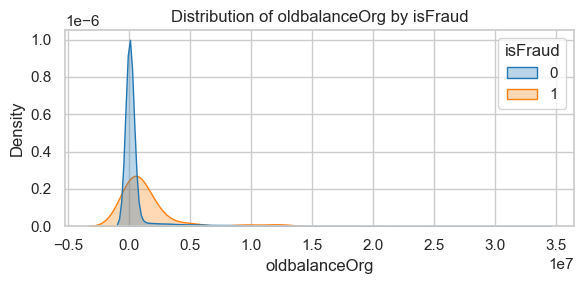

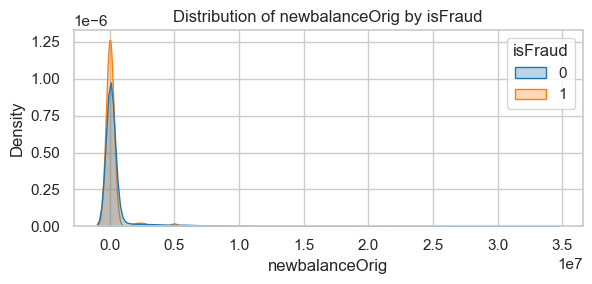

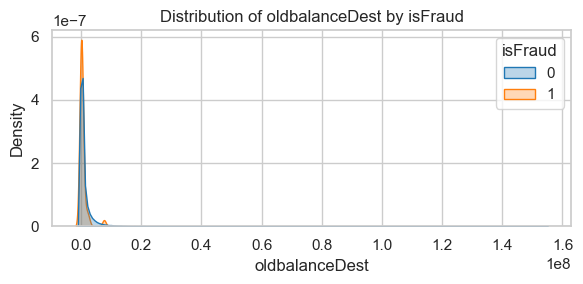

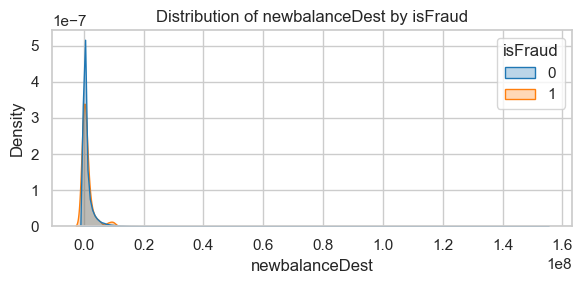

/var/folders/td/t81p57q93474xft5d0tdyfl00000gn/T/ipykernel_99987/2439016829.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=plot_df, x=c, hue='isFraud', common_norm=False, fill=True, alpha=0.3)


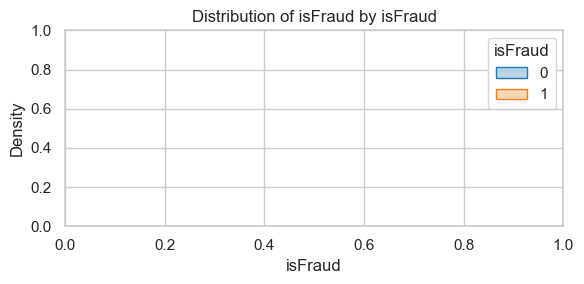

In [8]:
# ---- Distributions by class (sampled) ----
plot_df = df
if len(df) > PLOT_SAMPLE:
    plot_df = df.sample(PLOT_SAMPLE, random_state=RANDOM_STATE)
if 'isFraud' in plot_df.columns:
    for c in num_cols[:12]:
        plt.figure(figsize=(6,3))
        sns.kdeplot(data=plot_df, x=c, hue='isFraud', common_norm=False, fill=True, alpha=0.3)
        plt.title(f'Distribution of {c} by isFraud')
        plt.tight_layout()
        plt.show()
else:
    print('isFraud not in columns; skipping class-wise distributions.')


---
## Train XGBoost (default threshold 0.5)
Class imbalance handled via `scale_pos_weight`

Before SMOTE: {0: 5083526, 1: 6570}
After SMOTE : {0: 5083526, 1: 5083526}


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:23:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report (thr=0.5):
              precision    recall  f1-score   support

           0     1.0000    0.9976    0.9988   1270881
           1     0.3522    0.9933    0.5200      1643

    accuracy                         0.9976   1272524
   macro avg     0.6761    0.9955    0.7594   1272524
weighted avg     0.9992    0.9976    0.9982   1272524

Confusion Matrix (thr=0.5):
[[1267879    3002]
 [     11    1632]]
ROC AUC: 0.9996


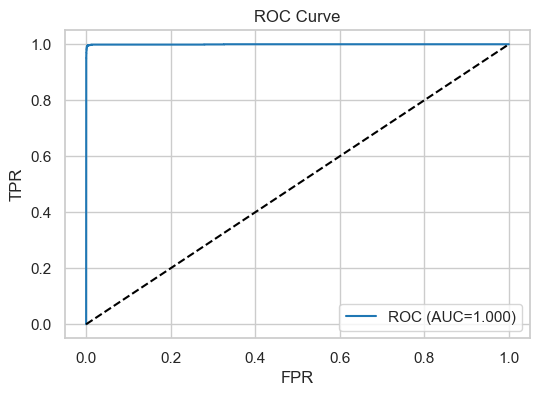

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import os
from imblearn.over_sampling import SMOTE

# Prepare features
df_model = df.copy()
for c in ('nameOrig','nameDest'):
    if c in df_model.columns:
        df_model = df_model.drop(columns=[c])

le = None
if 'type' in df_model.columns and df_model['type'].dtype.name in ('object','category'):
    le = LabelEncoder()
    df_model['type'] = le.fit_transform(df_model['type'].astype(str))

X = df_model.drop(columns=['isFraud']) if 'isFraud' in df_model.columns else df_model.copy()
y = df_model['isFraud'] if 'isFraud' in df_model.columns else None

if y is None:
    raise ValueError('isFraud column is required for training in this notebook')

# Cast numerics for memory
for c in X.columns:
    if pd.api.types.is_float_dtype(X[c]):
        X[c] = X[c].astype(np.float32)
    elif pd.api.types.is_integer_dtype(X[c]):
        X[c] = X[c].astype(np.int32)
        

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
xgb = XGBClassifier(
    n_estimators=300, learning_rate=0.1, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE,
    use_label_encoder=False, eval_metric='auc', n_jobs=-1, tree_method='hist'
)
print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE :", y_train_res.value_counts().to_dict())

xgb.fit(X_train_res, y_train_res, eval_set=[(X_val, y_val)], verbose=False)

# Evaluate at default threshold 0.5
y_pred = xgb.predict(X_val)
print('\nClassification Report (thr=0.5):')
print(classification_report(y_val, y_pred, digits=4))
print('Confusion Matrix (thr=0.5):')
print(confusion_matrix(y_val, y_pred))

# ROC
y_proba = xgb.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_proba)
print(f'ROC AUC: {auc:.4f}')
fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC (AUC={auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.show()


## SHAP Feature Importance
TreeExplainer on XGBoost; uses sampled background and validation for speed.

 99%|===================| 1984/2000 [00:15<00:00]        

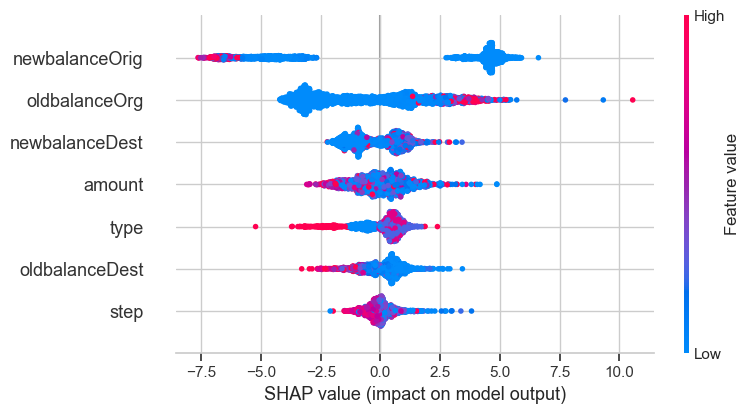

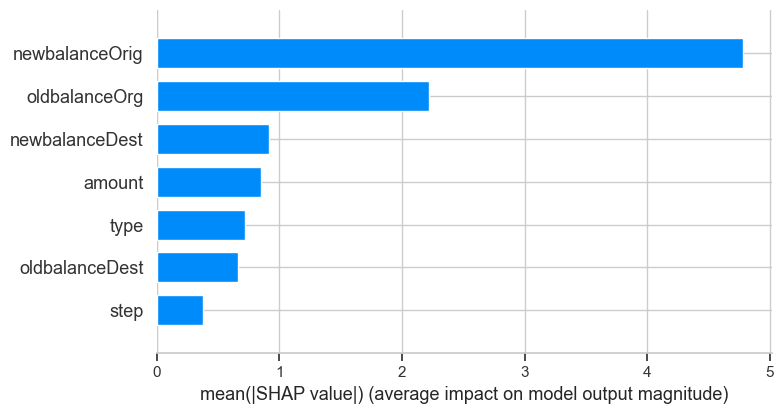

In [10]:
try:
    import shap
except ImportError:
    raise SystemExit('SHAP not installed. Please run: pip install shap')

bg_sample = X_train.sample(n=min(SHAP_BG_MAX, len(X_train)), random_state=RANDOM_STATE)
val_sample = X_val.sample(n=min(SHAP_VAL_MAX, len(X_val)), random_state=RANDOM_STATE)
explainer = shap.TreeExplainer(xgb, data=bg_sample)
shap_values = explainer.shap_values(val_sample)
shap.summary_plot(shap_values, val_sample, show=True)
shap.summary_plot(shap_values, val_sample, plot_type='bar', show=True)


## Save Model Bundle (.pkl)
Saves model, label encoder, feature names, and AUC for reuse in prediction scripts.

In [11]:
from pathlib import Path
Path(MODELS_DIR).mkdir(exist_ok=True)
artifacts = {
    'model': xgb,
    'label_encoder': le,
    'feature_names': list(X.columns),
    'auc': float(auc),
}
pkl_path = Path(MODELS_DIR) / 'fraud_pipeline.pkl'
try:
    import joblib
    joblib.dump(artifacts, str(pkl_path))
    print('Saved pickle bundle:', pkl_path.resolve())
except Exception:
    import pickle
    with open(pkl_path, 'wb') as f:
        pickle.dump(artifacts, f, protocol=pickle.HIGHEST_PROTOCOL)
    print('Saved pickle bundle (pickle):', pkl_path.resolve())


Saved pickle bundle: /Users/basanktw/Swinburne/Semester4/COS80029/saved_models/fraud_pipeline.pkl
